In [1]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import seaborn as sn

In [4]:
plt.close("all")

In [6]:
# Create dataset

def make_circles(num_samples): # nonlinearly separable
    
    return datasets.make_circles(num_samples)

# can specify an x y and z for stdeviations to get interesting datasets
def make_clouds(num_samples, all_means, all_stds, num_features = 2):
    
    all_samples, all_labels = [], []
    for i, (mean, std) in enumerate(zip(all_means, all_stds)):
       
        all_samples.append(np.random.normal(mean, std, (num_samples, num_features)))
        all_labels.append([i] * num_samples)
        
    return np.vstack(all_samples), np.hstack(all_labels)

# Create visualization of dataset

def show_data(all_samples, all_labels, title):
    
    plt.style.use("seaborn")
    
    fig, ax = plt.subplots()
    ax.scatter(all_samples[:, 0], all_samples[:, 1], c = all_labels, cmap = "Set2")
    ax.set_xlabel("X0")
    ax.set_ylabel("X1")
    ax.set_title(title)
    fig.tight_layout()

(3000, 2) (3000,) 3


/var/folders/lh/6svpwf5n6zzg8m2whfkn1n2h0000gn/T/ipykernel_2142/3217761024.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


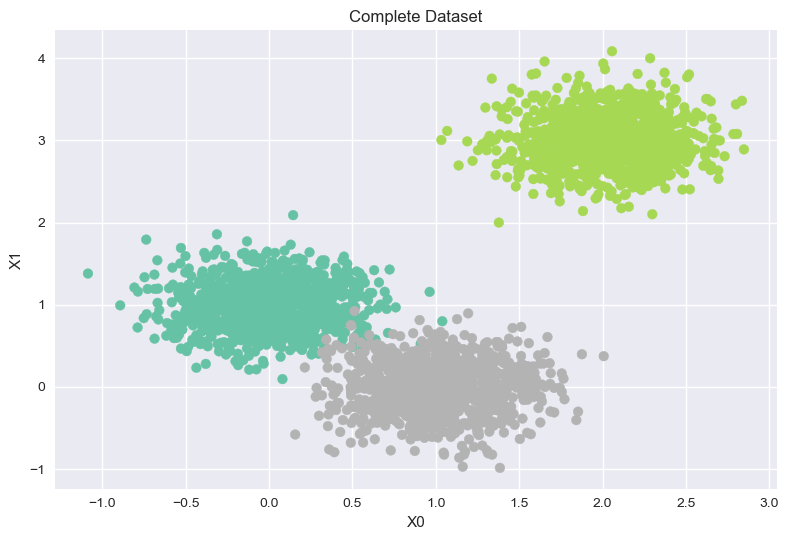

In [33]:
num_samples = 1000
num_features = 2

all_means = [(0, 1), (2, 3), (1, 0)]
all_stds = [0.3, 0.3, 0.3] #make this multivariant by doing [(0.3, 0.3), (0.3, 0.3)] gives control over shape making

all_samples, all_labels = make_clouds(num_samples, all_means, all_stds, num_features)
#all_samples, all_labels = make_circles(num_samples)

num_classes = len(np.unique(all_labels))

print(all_samples.shape, all_labels.shape, num_classes)

show_data(all_samples, all_labels, "Complete Dataset")

# all_samples shape = 2000x2 -> 2k samples where each sample is a 1x2
# 3 every sample has an x, y value, plotted on the graph

# all_labels = 2000x1 only has truth value 


In [34]:
# Cross Validation Example

def create_cross_validation(all_samples, all_labels, num_folds):
    
    # Shuffle data and labels
    
    num_samples = len(all_labels)
    
    indices = np.arange(0, num_samples)

    np.random.shuffle(indices)
    
    all_labels = all_labels[indices]
    all_samples = all_samples[indices]
    
    # Create folds
    
    folds = {}
    
    start, stop = 0, num_samples // num_folds
    
    for i in range(num_folds):
        
        test_fold_samples = all_samples[start:stop]
        test_fold_labels = all_labels[start:stop]
        
        if(i == 0):
            train_fold_samples = all_samples[stop:]
            train_fold_labels = all_labels[stop:]
        else:
            
            train_fold_samples = []
            train_fold_labels = []
            
            # Gather train data before test fold
            
            train_fold_samples.append(all_samples[:start])
            train_fold_labels.append(all_labels[:start])
            
            # Gather train data after test fold
            
            train_fold_samples.append(all_samples[stop:])
            train_fold_labels.append(all_labels[stop:])
                
            train_fold_samples = np.vstack(train_fold_samples)
            train_fold_labels = np.hstack(train_fold_labels)
              
        print("CV Fold = %s, Start = %s, Stop = %s, Train Data Shape = %s, Test Data Shape = %s" % (i, start, stop, train_fold_samples.shape, test_fold_samples.shape))
        
        # Update counters
        
        start = stop
        stop = stop + num_samples // num_folds
        
        # Update fold information
        
        folds[i] = {"train": [train_fold_samples, train_fold_labels],
                    "test" :  [test_fold_samples, test_fold_labels]}
        
    return folds

folds = create_cross_validation(all_samples, all_labels, 4)

CV Fold = 0, Start = 0, Stop = 750, Train Data Shape = (2250, 2), Test Data Shape = (750, 2)
CV Fold = 1, Start = 750, Stop = 1500, Train Data Shape = (2250, 2), Test Data Shape = (750, 2)
CV Fold = 2, Start = 1500, Stop = 2250, Train Data Shape = (2250, 2), Test Data Shape = (750, 2)
CV Fold = 3, Start = 2250, Stop = 3000, Train Data Shape = (2250, 2), Test Data Shape = (750, 2)


/var/folders/lh/6svpwf5n6zzg8m2whfkn1n2h0000gn/T/ipykernel_2142/3217761024.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/var/folders/lh/6svpwf5n6zzg8m2whfkn1n2h0000gn/T/ipykernel_2142/3217761024.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


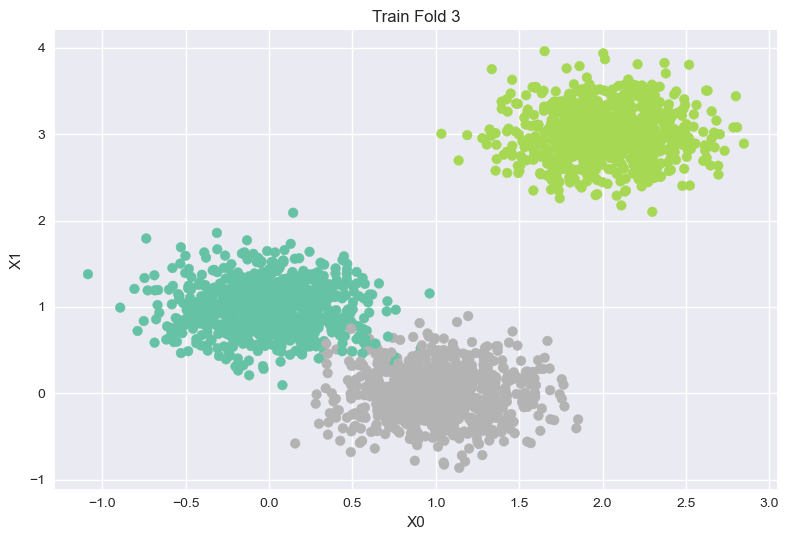

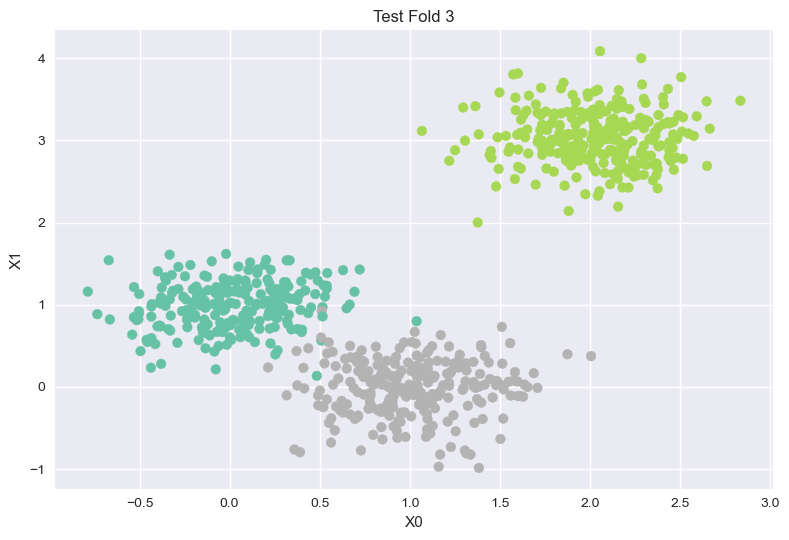

In [35]:
fold_index = 3

all_train_samples, all_train_labels = folds[fold_index]["train"]

show_data(all_train_samples, all_train_labels, "Train Fold %s" % (fold_index))

all_test_samples, all_test_labels = folds[fold_index]["test"]

show_data(all_test_samples, all_test_labels, "Test Fold %s" % (fold_index))

In [36]:
# Format dataset for pytorch

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, samples, labels):
        
        super(Dataset, self).__init__()
        
        self.create_dataset(samples, labels)
        
    def create_dataset(self, all_samples, all_labels):
        
        self.dataset = []
        
        for sample, label in zip(all_samples, all_labels):
            self.dataset.append((torch.tensor(sample).float(), torch.tensor(label).long())) #samples floats, labels long

    def __getitem__(self, index):
                                        
        return self.dataset[index]                            
        
    def __len__(self):
        
        return len(self.dataset)

In [37]:
batch_size = 16

# Uncomment to test complete dataset via resub
# 1 
#using all samles & all labels, not using cross validation. this is reesub (memorizee)
#train_dataset = Dataset(all_samples, all_labels)
#valid_dataset = Dataset(all_samples, all_labels)

# generalize
# now we have test samples and test labels so we can use cross validation. have to change whihc fold you're looking at
train_dataset = Dataset(all_train_samples, all_train_labels)

# 2 
# Uncomment for resub with cross validation (optional, for debugging the model)
#valid_dataset = Dataset(all_train_samples, all_train_labels) 
# Uncomment for testing
valid_dataset = Dataset(all_test_samples, all_test_labels) 

# 3
# actually creating the dataloader. this will feed data to the model, allow us to use these paramaters
# this is the "ultimate" step
train_dataset = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataset = torch.utils.data.DataLoader(valid_dataset, batch_size = 1, shuffle = False)

In [38]:
# Create Network

class MLP(torch.nn.Module):
    
    def __init__(self, learning_rate, num_features, num_classes):
    
        super(MLP, self).__init__()
    
        self.alpha = learning_rate
        # don't change linear. change reLu
        self.network = torch.nn.Sequential(torch.nn.Linear(num_features, 128), # num features per input, num of neurons in the layer
                                           torch.nn.ReLU(), # every neuron goes through a relu output. 128 relus
                                           torch.nn.Linear(128, 64),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(64, num_classes))
        
    def init_optimizer(self):
        # play with parameter, momentum
        self.optimizer = torch.optim.SGD(self.parameters(), lr = self.alpha)
        
        # learns the best learning rate and gradient descent
        #self.optimizer = torch.optim.Adam(self.parameters(), lr = self.alpha)

    def objective(self, preds, labels):
        # use mean squred error too.
        obj = torch.nn.CrossEntropyLoss()

        return obj(preds, labels)

    def forward(self, x):

        return self.network(x)
        
model = MLP(1e-3, num_features, num_classes)

In [39]:
# eventually replace this with confu matrix

def calculate_accuracy(all_preds, all_labels):

    accuracy = 0
    for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
        
        #pred = np.argmax(pred)
        
        if(pred == label):
            accuracy = accuracy + 1
    
    return accuracy / (i + 1)
# calculate accuracy on testing data, loss on training data

In [40]:
# Init optimzizer

model.init_optimizer()

# Train and validate network

num_epochs = 200

training_loss, training_acc = [], []

for epoch in tqdm(range(num_epochs), desc = "Training"):
    
    # Train network
    
    model.train()
    
    epoch_loss = 0
    for i, (sample, label) in enumerate(train_dataset):
        
        preds = model(sample)
        
        loss = model.objective(preds, label)
        
        epoch_loss = epoch_loss + loss.item()
        
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
    
    epoch_loss = epoch_loss / (i + 1) # do this in training mode becuase we are averaging all the losses for the whole dataset, so loss associated with each sample
    
    training_loss.append(epoch_loss)
    
    # Validate network
    
    model.eval() # pause to calculate accuracy
    
    all_labels, all_preds = [], []
    for i, (sample, label) in enumerate(valid_dataset):
        
        pred = model(sample)
        pred = torch.argmax(pred)
        
        all_preds.append(pred.detach().numpy())
        all_labels.append(label.numpy())
        
    #print(all_preds)
    
    #and/or confustion matrix
    epoch_accuracy = calculate_accuracy(np.asarray(all_preds), np.asarray(all_labels))
    
    training_acc.append(epoch_accuracy)

Training:   0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
def plot_results(results, title, acc = 0):
    
    num_epochs = len(results)
    
    epochs = np.arange(0, num_epochs, 1)
    
    fig, ax = plt.subplots()
    
    ax.plot(epochs, results, "-o", linewidth = 4)
    ax.set_xlabel("Epochs")
    ax.set_ylabel(title)
    
    if(acc):
        ax.set_ylim([0, 1.05])
    
    fig.tight_layout()

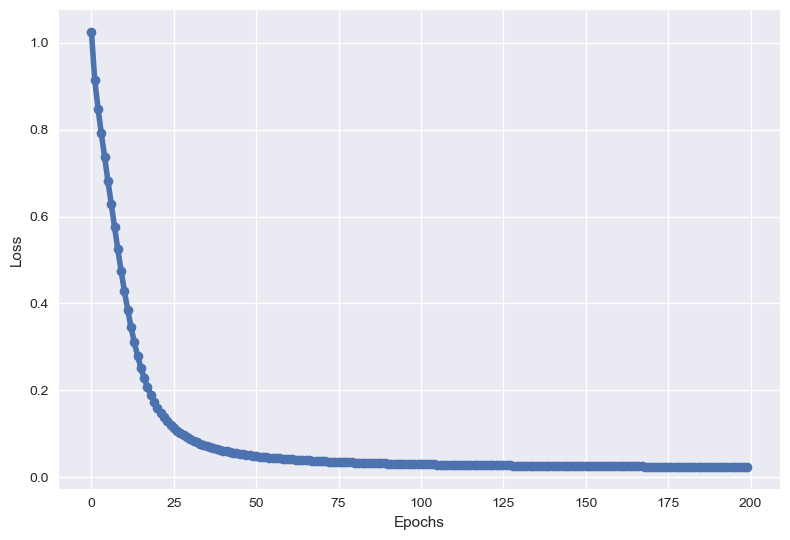

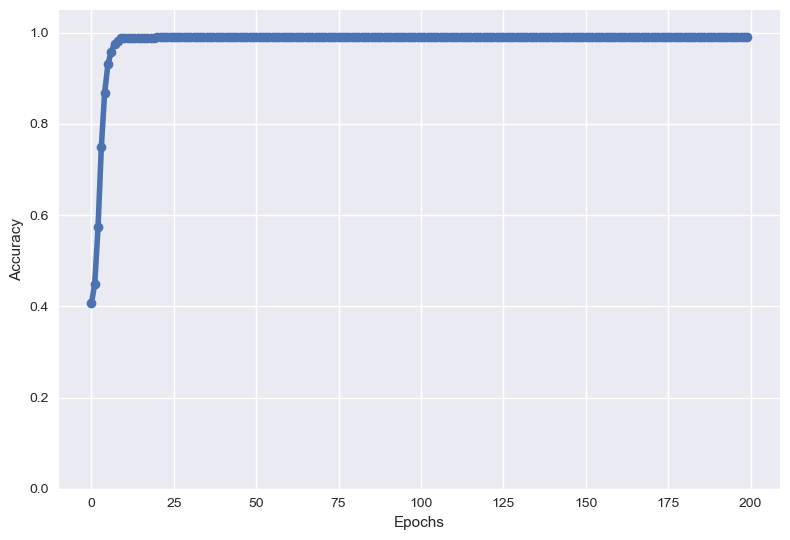

In [42]:
plot_results(training_loss, "Loss")
plot_results(training_acc, "Accuracy", acc = 1)

(750,) (750,)


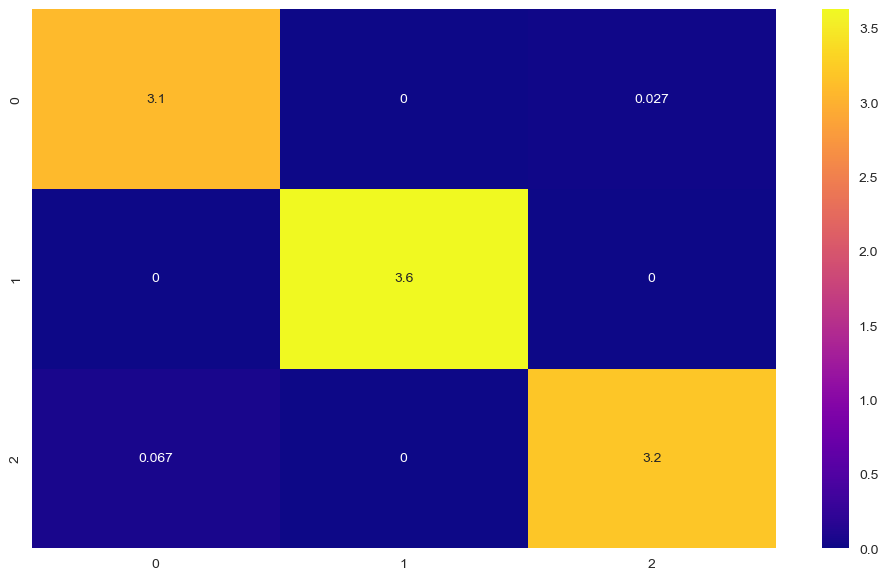

[[231   0   2]
 [  0 272   0]
 [  5   0 240]]


In [50]:
all_labels = np.asarray(all_labels)
all_preds = np.asarray(all_preds)
# for each prediction, actually get the prediction out from the model.
# to do that, we use argmax
all_labels = all_labels.reshape(-1) # flatten everything

print(all_labels.shape, all_preds.shape)
cf_matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index = [i for i in range(num_classes)], columns = [i for i in range(num_classes)])

plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot = True, cmap ="plasma")
plt.show()
print(cf_matrix)